# 3D reconstruction using 2 image

Key References
- https://www.opencvhelp.org/tutorials/advanced/reconstruction-opencv/

In [2]:
from __future__ import annotations

import os
import random as rd
from typing import TYPE_CHECKING

import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyrender
import scipy.spatial.transform as sci_trans

from project_3d_reconstruction.rendering import render_helper as rh

if TYPE_CHECKING:
    from mpl_toolkits.mplot3d.axes3d import Axes3D

# Generate simple scene

In [3]:
FILE_PATH = os.path.abspath(
    os.path.join(
        os.path.abspath("pyrender_basic_reconstruction.ipynb"), "..", "..", "mesh_files"
    )
)
OBJECTS = [
    #os.path.join(FILE_PATH, "building", "untitled.dae"),
    os.path.join(FILE_PATH, "coral_2", "untitled.dae"),
    os.path.join(FILE_PATH, "coral_4", "untitled.dae"),
    os.path.join(FILE_PATH, "rock_1", "untitled.dae"),
    os.path.join(FILE_PATH, "braincoral_1", "untitled.dae"),
]

renderer = rh.RenderHelper()

# Load in mesh files
names = []
for file_path in OBJECTS:
    print(f"Loading {file_path}")
    name = file_path.split("\\")[-2]  # warning slash is different for linux vs windows
    names.append(name)
    renderer.loadFromPath(file_path, name)
print("Done loading")

# Place them in the world
for i in range(1):
    object_name = rd.choice(names)
    renderer.addFromMeshDict('coral_4', rh.positionOnly(0,0,-0.3))

# # Add some cubes
# for i in range(10):
#     renderer.addCube(
#         np.random.uniform(0.1, 0.4),
#         rh.randomTransform(1),
#         color=np.random.randint(0, 180, 3),
#     )

Loading c:\Code\Project3DReconstruction\mesh_files\coral_2\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\coral_4\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\rock_1\untitled.dae
Loading c:\Code\Project3DReconstruction\mesh_files\braincoral_1\untitled.dae
Done loading


# test image from two perspectives.

In [4]:
#it got annoying making edits in render helper so its here now (TODO move it back)
#NOTE z is out, y is up (image y might be flipped), x is right
def toOriginPose2(x, y, z):
    #azimuth from xz plane
    az_rad = np.arctan2(x,z)
    #rotation about y axis
    Ry = np.array([[np.cos(az_rad), 0, np.sin(az_rad)],
                  [0,1,0],
                  [-np.sin(az_rad),0,np.cos(az_rad)]])
    
    el_rad = np.arctan2(-y, np.sqrt(x**2 + z**2))
    Rx = np.array([[1,0,0],
                  [0,np.cos(el_rad),-np.sin(el_rad)],
                  [0,np.sin(el_rad), np.cos(el_rad)]])
    R = Rx@Ry
    Rstack = np.hstack((R,np.array([[x, y, z]]).T))
    return np.vstack((Rstack, np.array([[0,0,0,1]])))

#wrapper for easy even spacing
def toOriginPose3(az_rad, el_rad, radius):
    y = radius * np.sin(el_rad)
    rproj = radius * np.cos(el_rad)
    x = rproj * np.sin(az_rad)
    z = rproj * np.cos(az_rad)
    return toOriginPose2(x,y,z)

#uncomment this for a comparison against old render method (spoiler it matches)

# # Render two views
# pose1 = rh.pointingAtOrigin2(0, 0.5)
# #pose1 = toOriginPose2(-0.1,2,2)

# renderer.moveCamera(pose1)
# renderer.render(show_image=False, image_filename="test1.png")

# pose2 = toOriginPose2(0,-0.5,0.5)
# renderer.moveCamera(pose2)
# renderer.render(show_image=False, image_filename="test2.png")

# image_1 = cv.imread("test1.png")
# image_2 = cv.imread("test2.png")

# # actual extrinsics
# print(pose1)
# print(pose2)
# relativePose = np.matmul(np.linalg.inv(pose1), pose2)
# print(relativePose)
# # camCopy = pyrender.IntrinsicsCamera(fx=512, fy=512, cx=256, cy=256)
# # print(camCopy.get_projection_matrix(width=512,height=512))

# gray_1 = cv.cvtColor(image_1, cv.COLOR_BGR2GRAY)
# gray_2 = cv.cvtColor(image_2, cv.COLOR_BGR2GRAY)

# ifig, iaxs = plt.subplots(ncols=2, figsize=(8, 8))
# iaxs[0].imshow(image_1, origin="lower")
# iaxs[1].imshow(image_2, origin="lower")
# ifig.tight_layout()


# save many images


C:\Users\Alex\AppData\Local\Temp\ipykernel_3804\2201353756.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  ifig.tight_layout()


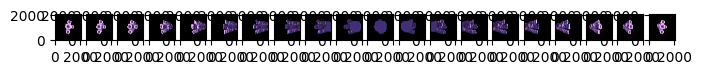

In [5]:
# Render three views
poses = []
images = []
numPoses = 20
azSpacing = 2.0*np.pi/numPoses
for i in range(numPoses):
    pose1 = toOriginPose3(azSpacing*i,0,0.7)
    renderer.moveCamera(pose1)
    renderer.render(show_image=False, image_filename="test"+str(i)+".png")
    poses.append(pose1)
    #TODO optimize this out if we're low on memory
    images.append(cv.imread("test"+str(i)+".png"))

# actual extrinsics
# print(pose1)
# print(pose2)
# relativePose = np.matmul(np.linalg.inv(pose1), pose2)
# print(relativePose)

gray_0 = cv.cvtColor(images[0], cv.COLOR_BGR2GRAY)
gray_1 = cv.cvtColor(images[1], cv.COLOR_BGR2GRAY)

ifig, iaxs = plt.subplots(ncols=numPoses, figsize=(8, 8))
for i in range(numPoses):
    iaxs[i].imshow(images[i], origin="lower")
ifig.tight_layout()


# Detect SIFT features

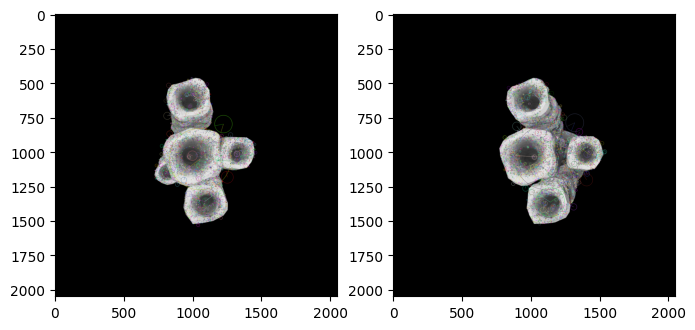

In [6]:
def opponentSIFT(img):
    # Step 1 convert to opponent color space
    # TODO optimize
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]

    O1 = np.divide((R - G), np.sqrt(2))
    O2 = np.divide((R + G - 2 * B), np.sqrt(6))
    O3 = np.divide((R + G + B), np.sqrt(3))
    # visually check opponent color space
    # cv.imwrite('sift_keypointsO1.jpg',np.uint8(O1))
    # cv.imwrite('sift_keypointsO2.jpg',np.uint8(O2))
    # cv.imwrite('sift_keypointsO3.jpg',np.uint8(O3))

    # Step 2 use Harris-Laplace point detector on intensity channel (o3)
    # TODO use a real point detector or figure out what parameters to use with cv SIFT
    # use this space to specify additional parameters
    sift = cv.SIFT_create()
    # sift = cv.SIFT_create(nfeatures=1000, nOctaveLayers=3, sigma=10)

    kp = sift.detect(np.uint8(O3), None)

    # Step 3 compute descriptors for each opponent channel
    _, des1 = sift.compute(np.uint8(O1), kp)
    _, des2 = sift.compute(np.uint8(O2), kp)
    _, des3 = sift.compute(np.uint8(O3), kp)

    # combine into one large descriptor
    des = np.concatenate((des1, des2, des3), axis=1)

    return kp, des

kpList=[]
desList=[]
for i in range(numPoses):
    kp,des = opponentSIFT(images[i])
    kpList.append(kp)
    desList.append(des)

image_kp_1 = cv.drawKeypoints(
    gray_0, kpList[0], images[0], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_kp_2 = cv.drawKeypoints(
    gray_1, kpList[1], images[1], flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

ifig, iaxs = plt.subplots(ncols=2, figsize=(8, 8))
iaxs[0].imshow(image_kp_1)
iaxs[1].imshow(image_kp_2)

# Match features (brute-force)

In [7]:
bf = cv.BFMatcher()

#matches between index i and i+1
bfMatchesList = []
for i in range(numPoses-1):
    bf_matches = bf.knnMatch(desList[i], desList[i+1], k=2)
    good = []

    for m, n in bf_matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
    bfMatchesList.append(good)


1695


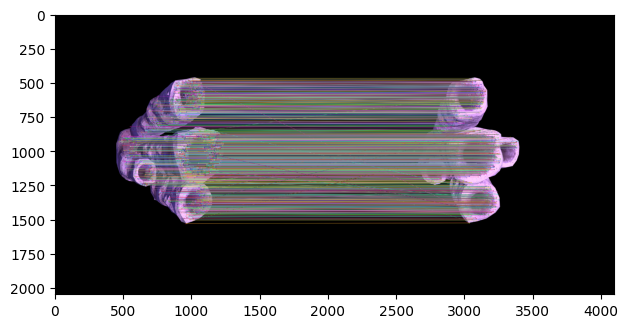

In [8]:

image_matches = cv.drawMatchesKnn(
    images[18],
    kpList[18],
    images[19],
    kpList[19],
    bfMatchesList[18],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


ifig, iax = plt.subplots()
iax.imshow(image_matches)
ifig.tight_layout()
print(len(good))

# Estimate essential matrix, filter points with ransac

In [9]:
# see pyrender script for intrinsic camera params
intrinsic_mat = np.array([[2048, 0, 1024], [0, 2048, 1024], [0, 0, 1]])

ransacMatches = []
fMatrices = []
for i in range(numPoses-1):
    good = bfMatchesList[i]
    kp1 = kpList[i]
    kp2 = kpList[i+1]
    points_1 = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
    points_2 = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)

    fMatrix, mask = cv.findFundamentalMat(
        points_1,
        points_2,
        method=cv.FM_RANSAC,
        ransacReprojThreshold=3,
        confidence=1 - 1e-6,
    )

    postRansac = []
    for i in range(len(mask)):
        if mask[i]:
            postRansac.append(good[i])
    ransacMatches.append(postRansac)
    fMatrices.append(fMatrix)



[[ 0.94860175  0.00135916  0.3164694  -0.99323266]
 [-0.00225399  0.99999443  0.00246149  0.00309973]
 [-0.31646429 -0.00304829  0.94859953  0.11610026]]
[[ 0.95105652  0.          0.30901699  0.2163119 ]
 [ 0.          1.          0.          0.        ]
 [-0.30901699  0.          0.95105652 -0.03426044]]


(-1.0, 1.0)

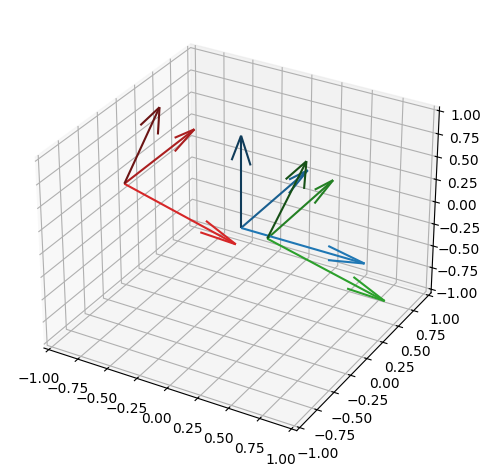

In [10]:

essential_mat = intrinsic_mat.T @ fMatrices[0] @ intrinsic_mat

good = ransacMatches[0]
kp1 = kpList[0]
kp2 = kpList[1]
points_1 = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
points_2 = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)

_, est_rot, est_trans, _ = cv.recoverPose(
    essential_mat, points_1, points_2, intrinsic_mat
)

est_extrinsic = np.hstack((est_rot, est_trans))

# act_rot = sci_trans.Rotation.align_vectors(dir_2, dir_1)[0].as_matrix()
# act_extrinsic = np.hstack((act_rot, np.reshape(dir_2 - dir_1, (-1, 1))))
# actual extrinsics
# print(pose1)
# print(pose2)
relativePose = np.matmul(np.linalg.inv(poses[0]), poses[1])
# print(relativePose)
act_extrinsic = relativePose[0:3, :]
print(est_extrinsic)
print(act_extrinsic)

origin = np.hstack((np.eye(3), np.zeros((3, 1))))

all_extrinsics = [origin, act_extrinsic, est_extrinsic]
base_colors = [
    mpl.colors.to_rgb("tab:blue"),
    mpl.colors.to_rgb("tab:green"),
    mpl.colors.to_rgb("tab:red"),
]
cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
for mat, color in zip(all_extrinsics, base_colors, strict=False):
    pos = mat[:, 3]
    for column, weight in zip(mat[:, :3].T, [1, 0.8, 0.5], strict=False):
        cax.quiver(*pos, *column, color=np.array(color) * weight)

cfig.tight_layout()
cax.set_xlim3d(-1, 1)
cax.set_ylim3d(-1, 1)
cax.set_zlim3d(-1, 1)
# cax.voxels(voxelarray, facecolors=colors, edgecolors=colors);

# note: rotation vectors stay aligned and translation is close enough (within scale factor)
#NOTE the chirality is messed up. pyrender camera has an inverted y axis. estimated translation will have the opposite direction

In [11]:
# turn feature points into 3D points using actual extrinsic matrix
points3DList = []
for i in range(numPoses-1):
    relativePose = np.matmul(np.linalg.inv(poses[i]), poses[i+1])
    R = relativePose[0:3, 0:3]
    T = relativePose[0:3, 3]

    kp1 = kpList[i]
    kp2 = kpList[i+1]
    good = ransacMatches[i]

    points_1_pr = np.int32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
    points_2_pr = np.int32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)
    f = 2048.0
    points3D = np.zeros((len(points_1_pr), 3))
    currentPose = poses[i]
    for index in range(len(points_1_pr)):
        point1 = points_1_pr[index]
        point2 = points_2_pr[index]
        #NOTE inverting y axis here
        #also converting from pixels to camera frame
        ray1 = np.array([point1[0][0]-1024, 1024-point1[0][1], f])  # *a
        ray2 = R @ np.array([point2[0][0]-1024, 1024-point2[0][1], f])
        skewSegment = np.cross(ray1, ray2)
        A = np.column_stack([ray1, -ray2, skewSegment])
        coeffs = np.linalg.solve(A, T)
        p13d = coeffs[0] * ray1
        p23d = T + coeffs[1] * ray2
        midpoint = (p13d + p23d) / 2.0

        # convert to world coordinates
        fourVec = np.concatenate([midpoint, [1]])
        points3D[index] = (currentPose @ fourVec)[0:3]
    points3DList.append(points3D)
print(points3DList[0])
print(points3DList[1])

[[ 0.07477919 -0.01213886 -0.03276776]
 [ 0.07301064 -0.02487692 -0.02940913]
 [ 0.07300252 -0.00105586 -0.03288811]
 ...
 [-0.11755351 -0.00670153  0.11136434]
 [-0.11836861 -0.02927468  0.11290424]
 [-0.11963469 -0.02894989  0.11082941]]
[[ 0.0724001  -0.01764114 -0.03070166]
 [ 0.07184712 -0.0059474  -0.03168308]
 [ 0.07139961  0.00033925 -0.03046031]
 ...
 [-0.1083048   0.00184761  0.1339859 ]
 [-0.10829332 -0.0047909   0.13399801]
 [-0.10848836 -0.00139142  0.13423685]]


[ 0.02498042 -0.02244998  0.21493587]


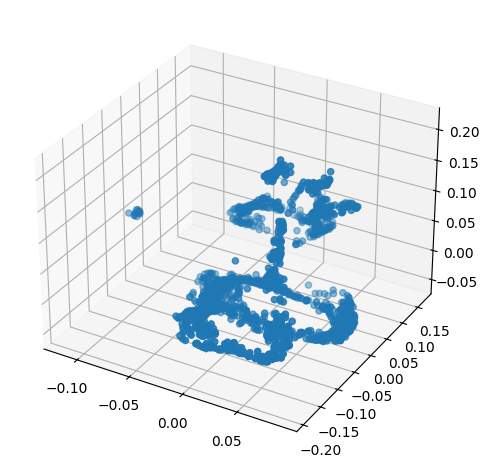

In [12]:
points3D = points3DList[18]
print(points3D[0])
# problem: sift feature points aren't always corners, not all corners make it to the final list either

cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
cax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2])
cfig.tight_layout()


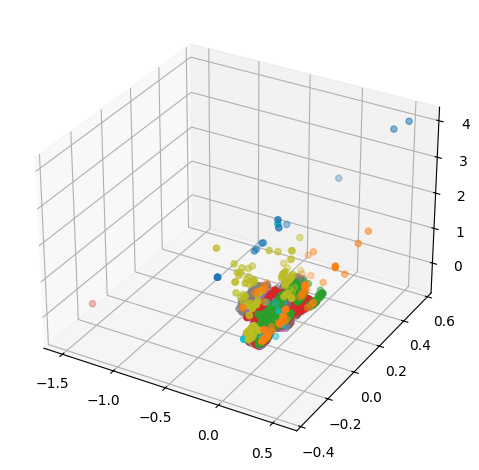

In [13]:
#all pts
cfig, cax = plt.subplots(subplot_kw={"projection": "3d"})
for points3D in points3DList:
    cax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2])
cfig.tight_layout()

Widget(value='<iframe src="http://localhost:51837/index.html?ui=P_0x1d846ece600_0&reconnect=auto" class="pyvis…

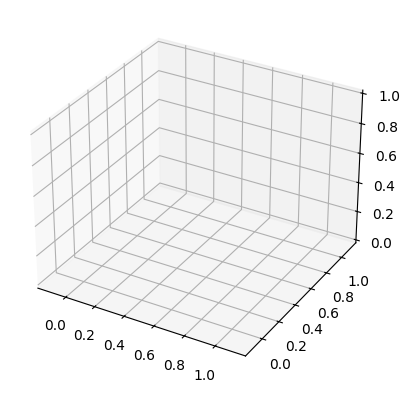

In [14]:
from project_3d_reconstruction.point_cloud_to_mesh import point_cloud_to_mesh_tester as pcloud
import pyvista as pv
import trimesh

#actual mesh
coralFile =  os.path.join(FILE_PATH, "coral_4", "untitled.dae")
mesh = trimesh.load(coralFile, force="mesh")
pc1 = pcloud.generatePointCloud(mesh, noise=0.0)
clusters1 = pcloud.extractClusters(pc1, distance_threshold=0.5)

# Plot it
pl1 = pv.Plotter(shape=(1, 2))
pl1.add_title("Point Cloud of 3D Surface")
pl1.add_mesh(pc1)
pl1.subplot(0, 1)
pl1.add_title("Reconstructed Surface")
for cluster in clusters1:
    surf = pcloud.pointsToSurface(cluster)
    pl1.add_mesh(surf, color=True, show_edges=True)
pl1.show()

In [15]:
flattenedPointsList = np.concatenate(points3DList)
print(flattenedPointsList)

#clusters = pcloud.extractClusters(flattenedPointsList, distance_threshold=0.5)

# Plot it
pl = pv.Plotter(shape=(1, 2))
pl.add_title("Point Cloud of 3D Surface")
pl.add_mesh(flattenedPointsList)
pl.subplot(0, 1)
pl.add_title("Reconstructed Surface")
# for cluster in clusters:
#     surf = pcloud.pointsToSurface(cluster)
#     pl.add_mesh(surf, color=True, show_edges=True)
pl.show()

[[ 0.07477919 -0.01213886 -0.03276776]
 [ 0.07301064 -0.02487692 -0.02940913]
 [ 0.07300252 -0.00105586 -0.03288811]
 ...
 [-0.11399055 -0.01878792  0.05977339]
 [-0.11399055 -0.01878792  0.05977339]
 [-0.11735233 -0.02706678  0.06216191]]


Widget(value='<iframe src="http://localhost:51837/index.html?ui=P_0x1d80a59b5c0_1&reconnect=auto" class="pyvis…